In [2]:
# In Google Colab: Install Kaggle API
!pip install kaggle

# Download the Kepler dataset directly
from google.colab import files
files.upload()  # Upload your Kaggle API key (kaggle.json)

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d keplersmachines/kepler-labelled-time-series-data
!unzip kepler-labelled-time-series-data.zip


Saving archive.zip to archive.zip
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open kepler-labelled-time-series-data.zip, kepler-labelled-time-series-data.zip.zip or kepler-label

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load data
train = pd.read_csv('exoTrain.csv')
test = pd.read_csv('exoTest.csv')

# Preprocess
X_train = train.drop('LABEL', axis=1).values
y_train = train['LABEL'].values - 1  # Convert labels to 0/1
X_test = test.drop('LABEL', axis=1).values
y_test = test['LABEL'].values - 1

# Reshape for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build model
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 5, activation='relu', input_shape=(3197, 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    class_weight={0: 1., 1: 50.})  # Fix class imbalance

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot a sample prediction
sample = X_test[0]
prediction = model.predict(sample.reshape(1, 3197, 1))[0][0]
plt.plot(sample, 'b-', label='Light Curve')
plt.title(f'Exoplanet Probability: {prediction:.2f}')
plt.show()

In [3]:
import pandas as pd
import numpy as np

# Load the dataset
train_df = pd.read_csv('/content/exoTrain.csv')
test_df = pd.read_csv('/content/exoTest.csv')

# Check the data
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("\nFirst few rows of training data:\n", train_df.head())

Training data shape: (5087, 3198)
Test data shape: (570, 3198)

First few rows of training data:
    LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6  FLUX.7  \
0      2    93.85    83.81    20.10   -26.98   -39.56  -124.71 -135.18   
1      2   -38.88   -33.83   -58.54   -40.09   -79.31   -72.81  -86.55   
2      2   532.64   535.92   513.73   496.92   456.45   466.00  464.50   
3      2   326.52   347.39   302.35   298.13   317.74   312.70  322.33   
4      2 -1107.21 -1112.59 -1118.95 -1095.10 -1057.55 -1034.48 -998.34   

    FLUX.8  FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  \
0   -96.27  -79.89  ...     -78.07    -102.15    -102.15      25.13   
1   -85.33  -83.97  ...      -3.28     -32.21     -32.21     -24.89   
2   486.39  436.56  ...     -71.69      13.31      13.31     -29.89   
3   311.31  312.42  ...       5.71      -3.73      -3.73      30.05   
4 -1022.71 -989.57  ...    -594.37    -401.66    -401.66    -357.24   

   FLUX.3192  FLUX.3193  FLUX.

In [4]:
# Convert labels to 0 (no planet) and 1 (planet)
train_df['LABEL'] = train_df['LABEL'] - 1
test_df['LABEL'] = test_df['LABEL'] - 1

# Separate features (flux) and labels
X_train = train_df.drop('LABEL', axis=1).values
y_train = train_df['LABEL'].values
X_test = test_df.drop('LABEL', axis=1).values
y_test = test_df['LABEL'].values

In [5]:
from sklearn.preprocessing import StandardScaler

# Normalize the flux values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for CNN (samples, time steps, channels)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print("Reshaped training data:", X_train_reshaped.shape)
print("Reshaped test data:", X_test_reshaped.shape)

Reshaped training data: (5087, 3197, 1)
Reshaped test data: (570, 3197, 1)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the model
model = Sequential([
    Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model (use class weights to handle imbalance)
class_weight = {0: 1., 1: 50.}  # Penalize misclassifying exoplanets more
history = model.fit(
    X_train_reshaped, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 3193, 32)            │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1596, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1594, 64)            │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 797, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51008)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,529,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,535,681 (24.93 MB)

 Trainable params: 6,535,681 (24.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9857 - loss: 1.3206 - val_accuracy: 1.0000 - val_loss: 0.4518
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9917 - loss: 0.8605 - val_accuracy: 1.0000 - val_loss: 0.4572
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9900 - loss: 0.9437 - val_accuracy: 1.0000 - val_loss: 0.4092
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9930 - loss: 0.7859 - val_accuracy: 1.0000 - val_loss: 0.5817
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9927 - loss: 0.8444 - val_accuracy: 1.0000 - val_loss: 0.4074
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9911 - loss: 0.9300 - val_accuracy: 1.0000 - val_loss: 0.2257
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9909 - loss: 0.8674 - val_accuracy: 1.0000 - val_loss: 0.3779
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9922 - loss: 0.8182 - val_accu

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9708 - loss: 0.3273

Test Accuracy: 99.12%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
Predicted probability of exoplanet: 0.2582


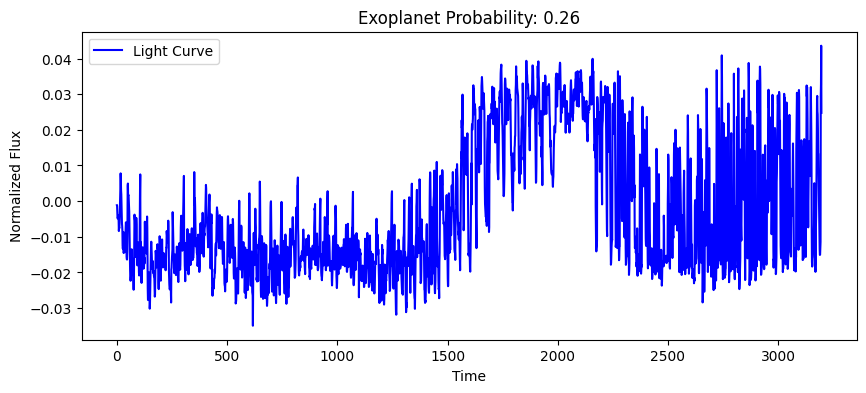

In [7]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

# Predict on a sample
sample = X_test_reshaped[0]
prediction = model.predict(sample.reshape(1, 3197, 1))[0][0]
print(f"Predicted probability of exoplanet: {prediction:.4f}")

# Plot a sample light curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(X_test_scaled[0], 'b-', label='Light Curve')
plt.title(f"Exoplanet Probability: {prediction:.2f}")
plt.xlabel("Time")
plt.ylabel("Normalized Flux")
plt.legend()
plt.show()